In [1]:
from typing import List, Dict, Optional
import torch

!pip install torch==1.12.0
!pip install diffusers==0.12.1
!pip install transformers==4.26.0
!pip install ftfy opencv-python ipywidgets matplotlib pyrallis jupyter accelerate

from google.colab import drive
drive.mount('/content/drive')

%cd 'drive/My Drive/Attention-Eraser'


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 1.12.0 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.12.0 which is incompatible.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.12.0 which is incompatible.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.12.0 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 13

In [2]:
!pip install jax==0.3.25 jaxlib==0.3.25 flax==0.6.2
from pipeline_attend_and_excite import AttendAndExcitePipeline
from config import RunConfig
from run import run_on_prompt, get_indices_to_alter
from utils import vis_utils
from utils.ptp_utils import AttentionStore

%load_ext autoreload 
%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 26.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of chex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 13.3 MB/s eta 0:00:00
  Created wheel for jax: filename=jax-0.3.25-py3-none-any.whl size=1308495 sha256=19eec4af64b00cff2966d5a66be76c5bebb9864d3725b160cf7abb7ffd42b2d7
  Stored in directory: /root/.cache/pip/wheels/41/0b/45/1acffcaf4c863a6d0d0e910e56ae6502ca8d16300e39e1dab2
Successfully built jax
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.7+cuda11.cudnn86
    Uninstalling jaxlib-0.4.

# Load Model Weights (may take a few minutes)

In [3]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable = AttendAndExcitePipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
tokenizer = stable.tokenizer

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


# Pipeline Wrapper

In [4]:
# configurable parameters (see RunConfig for all parameters)
# scale factor - intensity of shift by gradient
# thresholds - a dictionary for iterative refinement mapping the iteration number to the attention threshold
# max_iter_to_alter- maximal inference timestep to apply Attend-and-Excite
def run_and_display(prompts: List[str],
                    controller: AttentionStore,
                    indices_to_alter: List[int],
                    generator: torch.Generator,
                    run_standard_sd: bool = False,
                    scale_factor: int = 20,
                    thresholds: Dict[int, float] = {0:0.05, 10: 0.5, 20: 0.8},
                    max_iter_to_alter: int = 25,
                    display_output: bool = False,
                    sd_2_1: bool = False):
    config = RunConfig(prompt=prompts[0],
                       run_standard_sd=run_standard_sd,
                       scale_factor=scale_factor,
                       thresholds=thresholds,
                       max_iter_to_alter=max_iter_to_alter,
                       sd_2_1=sd_2_1)
    image = run_on_prompt(model=stable,
                          prompt=prompts,
                          controller=controller,
                          token_indices=indices_to_alter,
                          seed=generator,
                          config=config)
    if display_output:
        display(image)
    return image

# Run Inference on a Set of Seeds and Generate an Image Grid

In [5]:
def generate_images_for_method(prompt: str,
                               seeds: List[int],
                               indices_to_alter: Optional[List[int]] = None,
                               is_attend_and_excite: bool = True,
                               sd_2_1: bool = False):
    token_indices = get_indices_to_alter(stable, prompt) if indices_to_alter is None else indices_to_alter
    images = []
    for seed in seeds:
        g = torch.Generator('cuda').manual_seed(seed)
        prompts = [prompt]
        controller = AttentionStore()
        run_standard_sd = False if is_attend_and_excite else True
        image = run_and_display(prompts=prompts,
                                controller=controller,
                                indices_to_alter=token_indices,
                                generator=g,
                                run_standard_sd=run_standard_sd,
                                sd_2_1=sd_2_1)
        images.append(image.resize((256, 256)))
    grid = vis_utils.get_image_grid(images)
    display(grid)

# Stable Diffusion vs. Attend-and-Excite

## Stable Diffusion

{1: 'a', 2: 'little', 3: 'dog', 4: 'on', 5: 'the', 6: 'street'}
Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5): 2
Altering tokens: ['little']


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

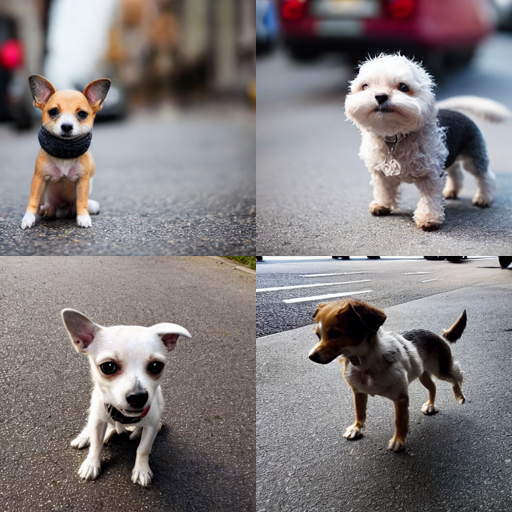

In [12]:
generate_images_for_method(
    prompt="a little dog on the street",
    seeds=[6141, 9031, 969, 3407],   #try random seed 3407
    is_attend_and_excite=False
)

## Attend-and-Excite

{1: 'a',
 2: 'man',
 3: 'walking',
 4: 'down',
 5: 'the',
 6: 'street',
 7: 'far',
 8: 'away'}
Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5): 2
Altering tokens: ['man']


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.0677
Iteration 1 | Loss: 0.0527
Iteration 2 | Loss: 0.0533
Iteration 3 | Loss: 0.0513
Iteration 4 | Loss: 0.0514
Iteration 5 | Loss: 0.0499
Iteration 6 | Loss: 0.0514
Iteration 7 | Loss: 0.0529
Iteration 8 | Loss: 0.0533
Iteration 9 | Loss: 0.0549
Iteration 10 | Loss: 0.0539
Iteration 11 | Loss: 0.0536
Iteration 12 | Loss: 0.0523
Iteration 13 | Loss: 0.0520
Iteration 14 | Loss: 0.0516
Iteration 15 | Loss: 0.0527
Iteration 16 | Loss: 0.0522
Iteration 17 | Loss: 0.0527
Iteration 18 | Loss: 0.0545
Iteration 19 | Loss: 0.0522
Iteration 20 | Loss: 0.0554
Iteration 21 | Loss: 0.0521
Iteration 22 | Loss: 0.0537
Iteration 23 | Loss: 0.0520
Iteration 24 | Loss: 0.0520


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.1208
Iteration 1 | Loss: 0.0995
Iteration 2 | Loss: 0.1006
Iteration 3 | Loss: 0.0678
Iteration 4 | Loss: 0.0559
Iteration 5 | Loss: 0.0497
Iteration 6 | Loss: 0.0471
Iteration 7 | Loss: 0.0457
Iteration 8 | Loss: 0.0443
Iteration 9 | Loss: 0.0435
Iteration 10 | Loss: 0.0428
Iteration 11 | Loss: 0.0430
Iteration 12 | Loss: 0.0435
Iteration 13 | Loss: 0.0453
Iteration 14 | Loss: 0.0460
Iteration 15 | Loss: 0.0461
Iteration 16 | Loss: 0.0450
Iteration 17 | Loss: 0.0450
Iteration 18 | Loss: 0.0444
Iteration 19 | Loss: 0.0452
Iteration 20 | Loss: 0.0456
Iteration 21 | Loss: 0.0462
Iteration 22 | Loss: 0.0468
Iteration 23 | Loss: 0.0473
Iteration 24 | Loss: 0.0477


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.0942
Iteration 1 | Loss: 0.0694
Iteration 2 | Loss: 0.0699
Iteration 3 | Loss: 0.0597
Iteration 4 | Loss: 0.0519
Iteration 5 | Loss: 0.0502
Iteration 6 | Loss: 0.0485
Iteration 7 | Loss: 0.0528
Iteration 8 | Loss: 0.0524
Iteration 9 | Loss: 0.0530
Iteration 10 | Loss: 0.0526
Iteration 11 | Loss: 0.0525
Iteration 12 | Loss: 0.0527
Iteration 13 | Loss: 0.0533
Iteration 14 | Loss: 0.0541
Iteration 15 | Loss: 0.0543
Iteration 16 | Loss: 0.0542
Iteration 17 | Loss: 0.0539
Iteration 18 | Loss: 0.0525
Iteration 19 | Loss: 0.0527
Iteration 20 | Loss: 0.0521
Iteration 21 | Loss: 0.0515
Iteration 22 | Loss: 0.0512
Iteration 23 | Loss: 0.0508
Iteration 24 | Loss: 0.0504


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.0688
Iteration 1 | Loss: 0.0596
Iteration 2 | Loss: 0.0597
Iteration 3 | Loss: 0.0567
Iteration 4 | Loss: 0.0560
Iteration 5 | Loss: 0.0644
Iteration 6 | Loss: 0.0567
Iteration 7 | Loss: 0.0510
Iteration 8 | Loss: 0.0512
Iteration 9 | Loss: 0.0459
Iteration 10 | Loss: 0.0480
Iteration 11 | Loss: 0.0434
Iteration 12 | Loss: 0.0437
Iteration 13 | Loss: 0.0431
Iteration 14 | Loss: 0.0455
Iteration 15 | Loss: 0.0487
Iteration 16 | Loss: 0.0467
Iteration 17 | Loss: 0.0495
Iteration 18 | Loss: 0.0516
Iteration 19 | Loss: 0.0514
Iteration 20 | Loss: 0.0506
Iteration 21 | Loss: 0.0501
Iteration 22 | Loss: 0.0506
Iteration 23 | Loss: 0.0506
Iteration 24 | Loss: 0.0514


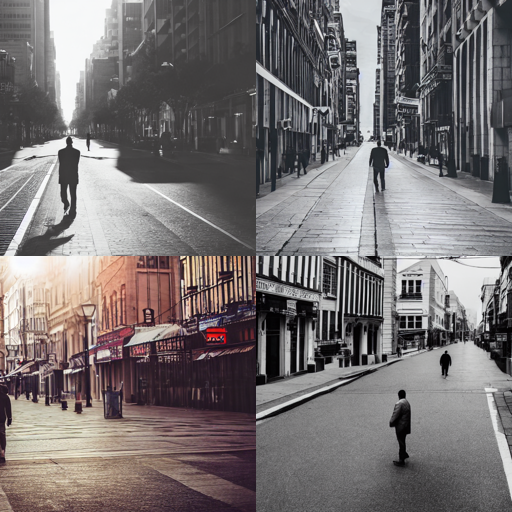

In [10]:
generate_images_for_method(
    prompt="a man walking down the street far away",
    seeds=[6141, 9031, 969, 3407],
    is_attend_and_excite=True
)